In [1]:
from pathlib import Path
import pandas as pd
from IPython.display import Image
from TELF.pipeline  import (
    AnimalBlock,
    DataBundle, 
    DIR_LIST_BUNDLE_KEY, 
    SAVE_DIR_BUNDLE_KEY, 
    RepeatLoopBlock,
    PipelineSummaryBlock,
    GroupSummaryBlock,
    BlockManager,
    DirectoryLoopBlock
)

In [2]:
class DummyMetricsBlock(AnimalBlock):  
    def __init__(self, increase=3):
        super().__init__(needs=(), provides=("df",), tag="DummyMetrics")
        self.increase = increase

    def run(self, bundle: DataBundle) -> DataBundle:
        idx = int(bundle.get("iter", 4))
        n_docs = idx * self.increase * 2 + 1
        df = pd.DataFrame({"doc_id": list(range(n_docs))})

        out = Path(bundle[SAVE_DIR_BUNDLE_KEY]) / self.tag
        out.mkdir(parents=True, exist_ok=True)
        csv = out / "df.csv"; df.to_csv(csv, index=False)

        bundle[f"{self.tag}.df"] = df
        self.register_checkpoint("df", csv)
        return bundle

In [3]:
ROOT = Path('example_results') / 'group_summary_example'

# SINGLE RUN

## Define the bundle

In [4]:
SINGLE_ROOT = ROOT / "single"
b = DataBundle({SAVE_DIR_BUNDLE_KEY: SINGLE_ROOT })

## Block manager definition and call

In [5]:
single_group_summary = GroupSummaryBlock(summary_block_tag="PipelineSummary")
mgr = BlockManager([
    DummyMetricsBlock(),
    single_group_summary
], databundle=b, verbose=False)

resultbundle = mgr()

[GroupSummary] needs → (save_path)   provides → (group_summary_df, group_summary_plot)
[DummyMetrics] needs → (∅)   provides → (df)


▶  [1/2] DummyMetrics …
✓  [1/2] DummyMetrics finished in 0.00s
▶  [2/2] GroupSummary …
✓  [2/2] GroupSummary finished in 0.28s


## View main result image

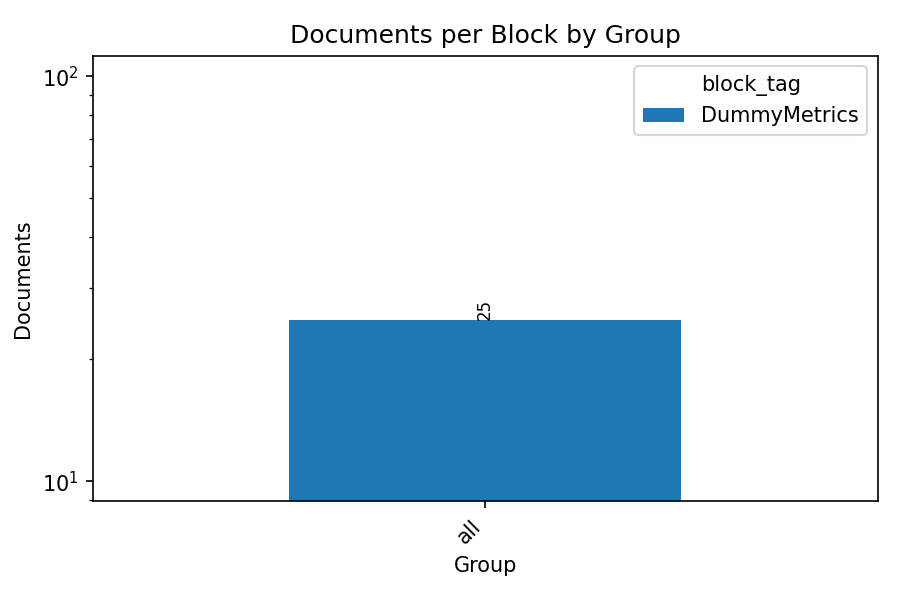

In [6]:
Image(resultbundle[single_group_summary.provides[1]])

## DIRECTORY LOOP

## Define directories and bundle

In [7]:
DIR_LOOP_ROOT = ROOT / "dirloop"
dirs = [DIR_LOOP_ROOT / d for d in ("dirA", "dirB")]
for d in dirs: d.mkdir(parents=True, exist_ok=True)
b = DataBundle({
    DIR_LIST_BUNDLE_KEY: dirs,
    SAVE_DIR_BUNDLE_KEY: DIR_LOOP_ROOT
})

## Block manager and dir loop definition and call

In [8]:

dir_loop = DirectoryLoopBlock(
    subblocks=[
        DummyMetricsBlock(increase=1),
        DummyMetricsBlock(increase=2),
        PipelineSummaryBlock()
    ],
    max_workers=1, 
    use_source_dir=True, 
    tag="MyDirLoop"
)

dirloop_group_summary = GroupSummaryBlock(
    summary_block_tag="PipelineSummary", 
    dir_loop_tag="MyDirLoop"
)

mgr = BlockManager(
    [
        dir_loop,
        dirloop_group_summary
    ], 
    databundle=b, 
    verbose=False,
)
outbundle = mgr()

[DummyMetrics] needs → (∅)   provides → (df)
[DummyMetrics] needs → (∅)   provides → (df)
[PipelineSummary] needs → (∅)   provides → (docs_summary_df, docs_summary_plot)
[MyDirLoop] needs → (directories)   provides → (results)
[GroupSummary] needs → (save_path)   provides → (group_summary_df, group_summary_plot)


▶  [1/2] MyDirLoop …


✓  [1/2] MyDirLoop finished in 0.34s
▶  [2/2] GroupSummary …
✓  [2/2] GroupSummary finished in 0.71s


## View main result image

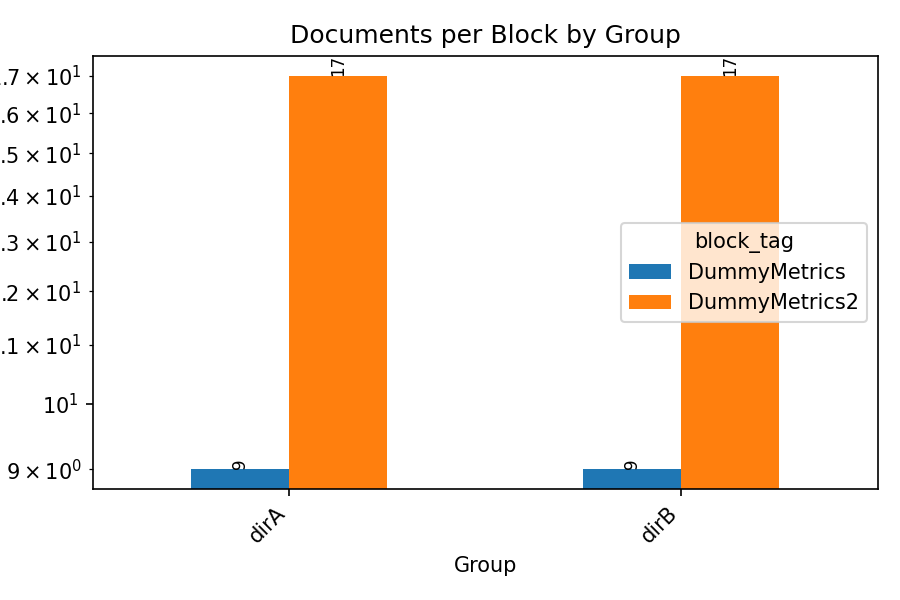

In [9]:
Image(filename=outbundle[dirloop_group_summary.provides[1]]) 

# REPEAT LOOP 

## Define directories and bundle

In [10]:
LOOP_ROOT = ROOT / "loop"
dirs = [LOOP_ROOT / d for d in ("dirA", "dirB")]
for d in dirs: d.mkdir(parents=True, exist_ok=True)

b = DataBundle({
    SAVE_DIR_BUNDLE_KEY: LOOP_ROOT
})


## Block manager and repeat loop definition and call

In [11]:
loop = RepeatLoopBlock(
    subblocks=[
        DummyMetricsBlock(increase=2),
        DummyMetricsBlock(increase=3),
        PipelineSummaryBlock()
    ],
    n_iter=4,
    clone=True,             # ← CHANGE HERE
    redirect_save_dir=True,
    tag="MyLoop"
)
repeatloop_group_summary =         GroupSummaryBlock(
            summary_block_tag="PipelineSummary",
            loop_tag="MyLoop"
        )
manager = BlockManager(
    blocks=[
        loop,
        repeatloop_group_summary
    ],
    databundle=b,
    verbose=False
)
result = manager()

[DummyMetrics] needs → (∅)   provides → (df)
[DummyMetrics] needs → (∅)   provides → (df)
[PipelineSummary] needs → (∅)   provides → (docs_summary_df, docs_summary_plot)
[MyLoop] needs → (∅)   provides → (results)
[GroupSummary] needs → (save_path)   provides → (group_summary_df, group_summary_plot)


▶  [1/2] MyLoop …


✓  [1/2] MyLoop finished in 0.55s
▶  [2/2] GroupSummary …
✓  [2/2] GroupSummary finished in 0.27s


## View main result image

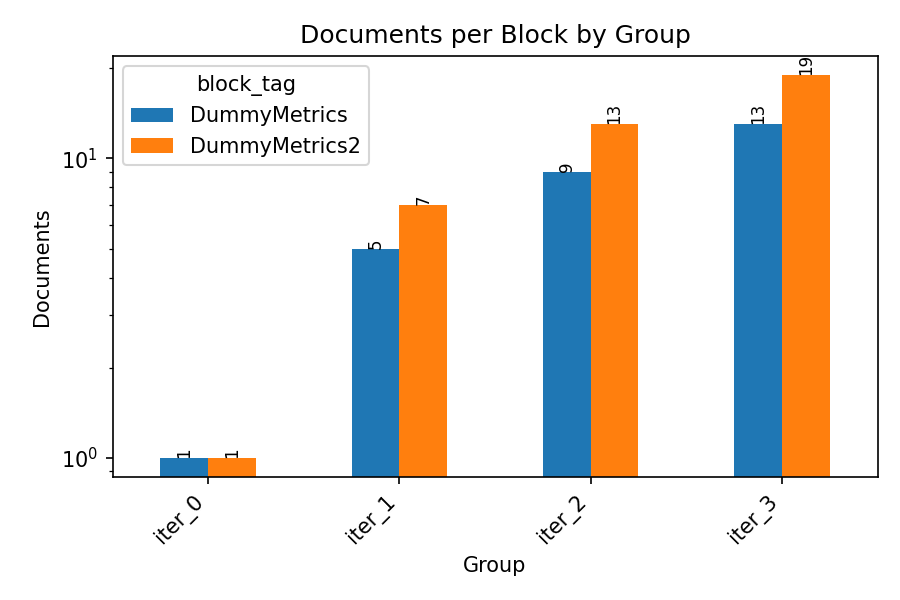

In [12]:
Image(result[repeatloop_group_summary.provides[1]])

# Nested dirloop then loop 

## Definitions and Call

In [13]:

LOOP_NEST1_ROOT = ROOT / "dirloop_then_loop"

dirs = [LOOP_NEST1_ROOT / name for name in ("dirA", "dirB")]
for d in dirs:
    d.mkdir(parents=True, exist_ok=True)

b = DataBundle({
    DIR_LIST_BUNDLE_KEY: dirs,
    SAVE_DIR_BUNDLE_KEY: LOOP_NEST1_ROOT
})

inner_loop = RepeatLoopBlock(
    subblocks=[
        DummyMetricsBlock(increase=2),
        DummyMetricsBlock(increase=3),
        PipelineSummaryBlock()
    ],
    n_iter=3,
    clone=True,             # preserve each iter’s summary in its own subfolder
    redirect_save_dir=True, # write each iter to its own sub-subfolder
    tag="InnerLoop"
)

outer_loop = DirectoryLoopBlock(
    subblocks=[inner_loop],
    max_workers=1,
    use_source_dir=True,  # pass source_dir into each dir_res
    tag="OuterLoop"
)

group_summary = GroupSummaryBlock(
    summary_block_tag="PipelineSummary",
    dir_loop_tag="OuterLoop",
    loop_tag="InnerLoop"
)

mgr = BlockManager(
    [outer_loop, group_summary],
    databundle=b,
    verbose=True
)
outresult = mgr()

[DummyMetrics] needs → (∅)   provides → (df)
[DummyMetrics] needs → (∅)   provides → (df)
[PipelineSummary] needs → (∅)   provides → (docs_summary_df, docs_summary_plot)
[InnerLoop] needs → (∅)   provides → (results)
[OuterLoop] needs → (directories)   provides → (results)
[GroupSummary] needs → (save_path)   provides → (group_summary_df, group_summary_plot)


Block (tag)                      │ Needs (✓/✗) │ Provides
─────────────────────────────────────────────────────────
DirectoryLoopBlock (OuterLoop)   │ directories │ ['results']
GroupSummaryBlock (GroupSummary) │ save_path   │ ['group_summary_df', 'group_summary_plot']

▶  [1/2] OuterLoop …


✓  [1/2] OuterLoop finished in 0.82s
▶  [2/2] GroupSummary …
✓  [2/2] GroupSummary finished in 0.34s


## View main result image

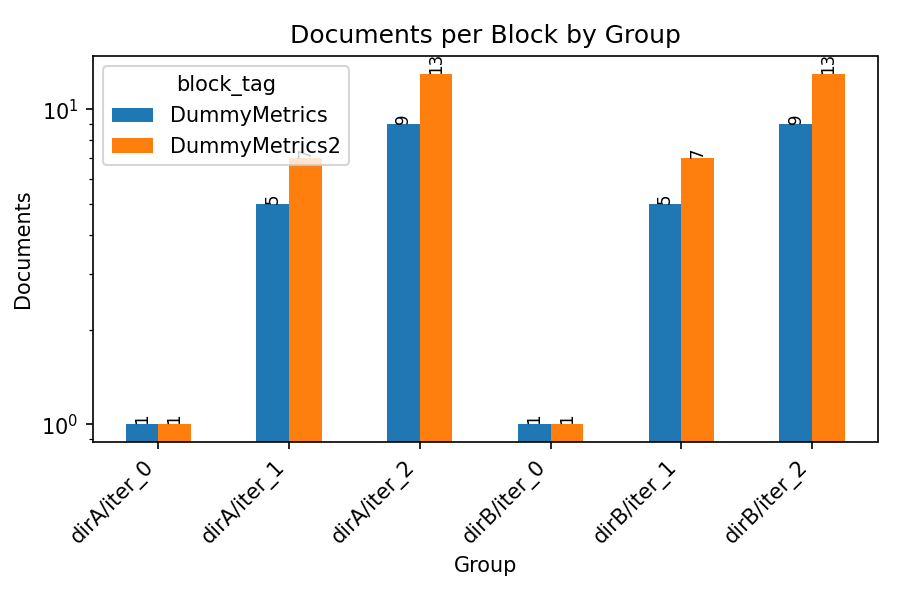

In [14]:
Image(outresult[group_summary.provides[1]])

# Nested loop then dirloop  

## Definitions and Call

In [15]:
LOOP_NEST2_ROOT = ROOT / "loop_then_dirloop"

dirs = [LOOP_NEST2_ROOT / d for d in ("dirA", "dirB")]
for d in dirs:
    d.mkdir(parents=True, exist_ok=True)

b = DataBundle({
    DIR_LIST_BUNDLE_KEY: dirs,
    SAVE_DIR_BUNDLE_KEY: LOOP_NEST2_ROOT
})
inner_dir = DirectoryLoopBlock(
    subblocks=[
        DummyMetricsBlock(increase=1),
        DummyMetricsBlock(increase=2),
        PipelineSummaryBlock()
    ],
    max_workers=1,
    use_source_dir=True,
    tag="MyDirLoop"
)
outer_loop = RepeatLoopBlock(
    subblocks=[inner_dir],
    n_iter=3,
    clone=True,             
    redirect_save_dir=True,  
    tag="MyLoop"
)
group_summary = GroupSummaryBlock(
    summary_block_tag="PipelineSummary",
    dir_loop_tag="MyDirLoop",
    loop_tag="MyLoop"
)
mgr = BlockManager(
    blocks=[outer_loop, group_summary],
    databundle=b,
    verbose=True
)
nested_result = mgr()

[DummyMetrics] needs → (∅)   provides → (df)
[DummyMetrics] needs → (∅)   provides → (df)
[PipelineSummary] needs → (∅)   provides → (docs_summary_df, docs_summary_plot)
[MyDirLoop] needs → (directories)   provides → (results)
[MyLoop] needs → (directories)   provides → (results)
[GroupSummary] needs → (save_path)   provides → (group_summary_df, group_summary_plot)


Block (tag)                      │ Needs (✓/✗) │ Provides
─────────────────────────────────────────────────────────
RepeatLoopBlock (MyLoop)         │ directories │ ['results']
GroupSummaryBlock (GroupSummary) │ save_path   │ ['group_summary_df', 'group_summary_plot']

▶  [1/2] MyLoop …


✓  [1/2] MyLoop finished in 0.30s
▶  [2/2] GroupSummary …
✓  [2/2] GroupSummary finished in 0.33s


## View main result image

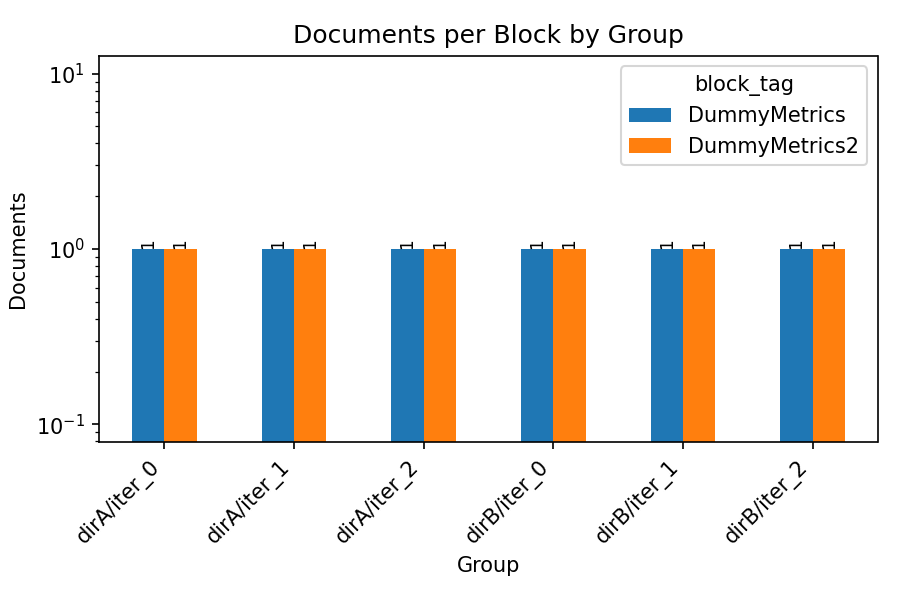

In [16]:
Image(nested_result[group_summary.provides[1]])